In [1]:
from subject_ajile12 import AjileSubject

subject_id, session_id = 1, 3
subject = AjileSubject(subject_id, session_id, cache=False)
subject.load_neural_data(session_id)

In [2]:
subject.get_reach_events(session_id)

,start_time,stop_time,Reach_magnitude_px,Reach_angle_degrees,Onset_speed_px_per_sec,Speech_ratio,Bimanual_ratio,Bimanual_overlap,Bimanual_class
id,,,,,,,,,
0,1791.954,1792.787333,132.213193,110.457915,201.584353,0.245755,0.953027,0.533333,1.0
1,3520.224,3521.190667,56.068108,-152.360333,94.011227,0.173995,0.029668,0.000000,0.0
2,3584.342,3585.308667,120.020850,-103.292386,156.464074,0.185332,0.005848,0.000000,0.0
3,26884.645,26885.678333,10.907912,-96.869164,4.466969,0.280051,0.000000,0.000000,0.0


In [3]:
subject.get_epochs(session_id)

,start_time,stop_time,labels
id,,,
0,0.000000,86.533333,Blocklist (Data break)
1,86.533333,206.200000,Sleep/rest
2,206.200000,206.400000,Blocklist (Data break)
3,206.400000,326.166667,Sleep/rest


In [9]:
subject.nwb_files[session_id].intervals['reaches']

,start_time,stop_time,Reach_magnitude_px,Reach_angle_degrees,Onset_speed_px_per_sec,Speech_ratio,Bimanual_ratio,Bimanual_overlap,Bimanual_class
id,,,,,,,,,
0,1791.954,1792.787333,132.213193,110.457915,201.584353,0.245755,0.953027,0.533333,1.0
1,3520.224,3521.190667,56.068108,-152.360333,94.011227,0.173995,0.029668,0.000000,0.0
2,3584.342,3585.308667,120.020850,-103.292386,156.464074,0.185332,0.005848,0.000000,0.0
3,26884.645,26885.678333,10.907912,-96.869164,4.466969,0.280051,0.000000,0.000000,0.0


In [16]:
import numpy as np
from ajilebench.ajilebench_config import *
def _get_nonreach_start_times(subject, trial_id, 
                              neural_data_nonreach_epoch_types=NEURAL_DATA_NONREACH_EPOCH_TYPES, 
                              neural_data_nonreach_window_padding_time=NEURAL_DATA_NONREACH_WINDOW_PADDING_TIME,
                              neural_data_nonreach_window_overlap=NEURAL_DATA_NONREACH_WINDOW_OVERLAP,
                              neural_data_nonreach_window_size=START_NEURAL_DATA_BEFORE_REACH_ONSET+END_NEURAL_DATA_AFTER_REACH_ONSET):
    reach_events = subject.get_reach_events(trial_id)
    epochs = subject.get_epochs(trial_id)

    start_times = []
    end_times = []

    epoch_start_times = epochs['start_time']
    epoch_end_times = epochs['stop_time']
    epoch_labels = epochs['labels']

    reach_start_times = np.array(reach_events['start_time'])-neural_data_nonreach_window_padding_time
    reach_end_times = np.array(reach_events['stop_time'])+neural_data_nonreach_window_padding_time

    for epoch_i in range(len(epoch_labels)):
        epoch_label = epoch_labels[epoch_i]
        if str(epoch_label) not in neural_data_nonreach_epoch_types: continue # Only consider allowed epoch types

        start_time = epoch_start_times[epoch_i]
        end_time = epoch_end_times[epoch_i]
        current_time = start_time
        while current_time + neural_data_nonreach_window_size < end_time:
            window_start = current_time
            window_end = current_time + neural_data_nonreach_window_size

            intersects_reach = np.any(
                ((window_start < reach_start_times) & (window_end > reach_start_times)) | \
                ((window_start < reach_end_times) & (window_end > reach_end_times)) | \
                ((window_start > reach_start_times) & (window_end < reach_end_times))
            )
            if intersects_reach:
                current_time += neural_data_nonreach_window_padding_time
                continue

            start_times.append(window_start)
            end_times.append(window_end)
            current_time += neural_data_nonreach_window_size * (1 - neural_data_nonreach_window_overlap)
    return np.array(start_times), np.array(end_times)

_get_nonreach_start_times(subject, 3)[0].shape

(4985,)

In [22]:
time_from, time_to = 687, 689
data = subject.get_all_electrode_data(4, int(time_from*subject.get_sampling_rate()), int(time_to*subject.get_sampling_rate()))

94


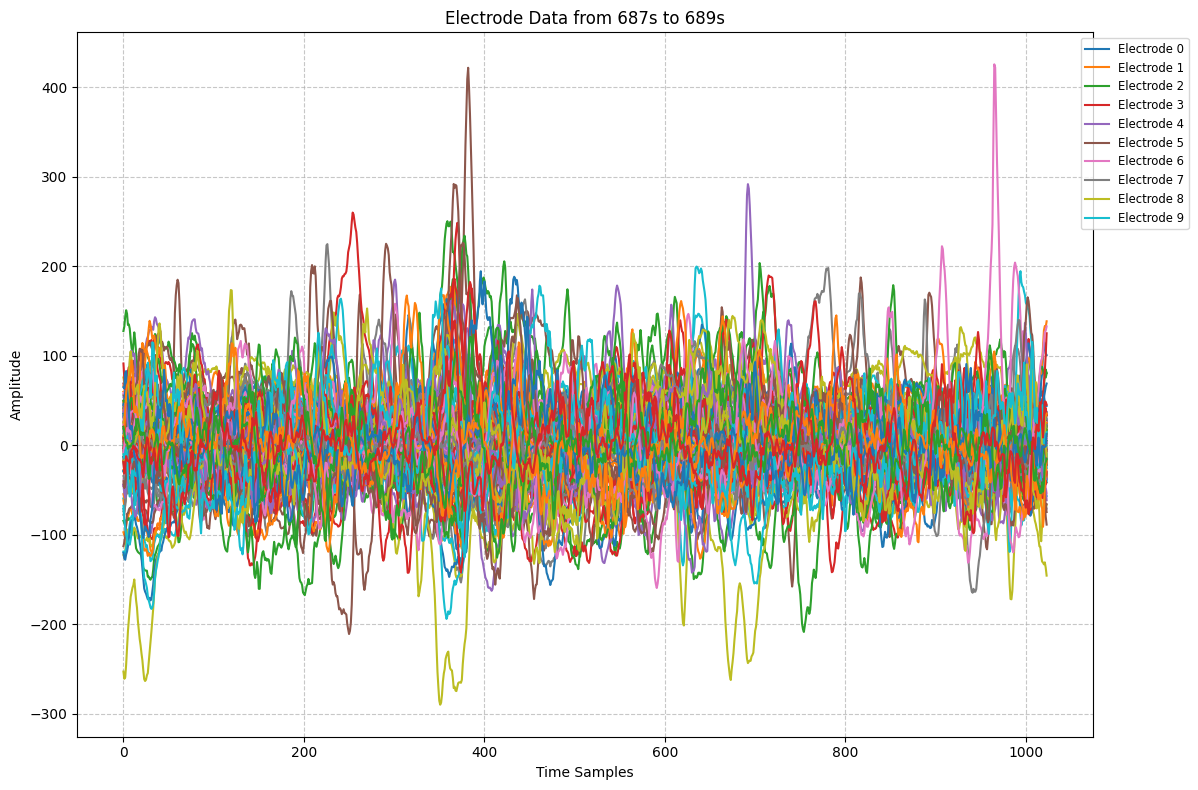

In [23]:
# Plot the electrode data
import matplotlib.pyplot as plt

# Check the shape of the data
print(data.shape[0])  # This should be 94 based on the context

# Create a figure
plt.figure(figsize=(12, 8))

# Plot each electrode's data as a line
for i in range(data.shape[0]):
    plt.plot(data[i].cpu().float().numpy(), label=f'Electrode {i}' if i < 10 else None)  # Only show labels for first 10 electrodes to avoid clutter

# Add labels and title
plt.xlabel('Time Samples')
plt.ylabel('Amplitude')
plt.title(f'Electrode Data from {time_from}s to {time_to}s')

# Add a legend for the first few electrodes
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1), fontsize='small')

# Show grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


In [16]:
subject.nwb_files[session_id].intervals['epochs'][:20]

,start_time,stop_time,labels
id,,,
0,0.000000,86.533333,Blocklist (Data break)
1,86.533333,206.200000,Sleep/rest
2,206.200000,206.400000,Blocklist (Data break)
3,206.400000,326.166667,Sleep/rest
4,326.166667,326.333333,Blocklist (Data break)
5,326.333333,446.033333,Sleep/rest
6,446.033333,446.166667,Blocklist (Data break)
7,446.166667,565.933333,Sleep/rest
8,565.933333,566.033333,Blocklist (Data break)


In [24]:
# Get unique elements from the epochs labels and count them
# VectorData doesn't have to_list() method, so convert to numpy array first
import numpy as np

# Get epochs data
epochs = subject.nwb_files[session_id].intervals['epochs']
labels_array = epochs['labels'][:]
start_times = epochs['start_time'][:]
stop_times = epochs['stop_time'][:]

# Calculate durations
durations = stop_times - start_times

# Get unique labels
unique_labels = np.unique(labels_array)

print("Unique labels:")
for label in unique_labels:
    # Count occurrences
    mask = labels_array == label
    count = np.sum(mask)
    
    # Calculate total time spent in this label
    total_time = np.sum(durations[mask])
    
    # Calculate mean duration per block
    mean_time = total_time / count if count > 0 else 0
    
    print(f"{label}: {count} occurrences")
    print(f"  Total time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
    print(f"  Mean time per block: {mean_time:.2f} seconds ({mean_time/60:.2f} minutes)")

Unique labels:
: 1 occurrences
  Total time: 118.83 seconds (1.98 minutes)
  Mean time per block: 118.83 seconds (1.98 minutes)
Blocklist (Camera move/zoom): 2 occurrences
  Total time: 238.93 seconds (3.98 minutes)
  Mean time per block: 119.47 seconds (1.99 minutes)
Blocklist (Data break): 714 occurrences
  Total time: 324.83 seconds (5.41 minutes)
  Mean time per block: 0.45 seconds (0.01 minutes)
Blocklist (Experiment): 88 occurrences
  Total time: 10792.10 seconds (179.87 minutes)
  Mean time per block: 122.64 seconds (2.04 minutes)
Blocklist (Private time): 35 occurrences
  Total time: 4197.23 seconds (69.95 minutes)
  Mean time per block: 119.92 seconds (2.00 minutes)
Blocklist (Tether/bandage): 13 occurrences
  Total time: 1552.67 seconds (25.88 minutes)
  Mean time per block: 119.44 seconds (1.99 minutes)
Computer/phone: 16 occurrences
  Total time: 1920.90 seconds (32.01 minutes)
  Mean time per block: 120.06 seconds (2.00 minutes)
Eat, TV: 12 occurrences
  Total time: 1442.9

In [29]:
import pynwb
from pynwb import NWBHDF5IO

# Path to the NWB file
nwb_file_path = os.path.join(AJILE_ROOT_DIR, "sub-01", "sub-01_ses-3_behavior+ecephys.nwb")

# Open the NWB file
io = NWBHDF5IO(nwb_file_path, 'r', load_namespaces=True)

nwb = io.read()

# Print basic information about the file
print(f"NWB File: {nwb_file_path}")
print(f"NWB File ID: {nwb.identifier}")
print(f"Session Description: {nwb.session_description}")
print(f"Session Start Time: {nwb.session_start_time}")

# Explore the structure of the file
print("\nFile Structure:")
for group_name, group in nwb.fields.items():
    print(f"- {group_name}")
    
    # If it's a container with items, show some of them
    if hasattr(group, 'items') and callable(group.items):
        for key, value in list(group.items())[:5]:  # Show first 5 items
            print(f"  - {key}: {type(value)}")
    
# Check for electrode information
if hasattr(nwb, 'electrodes'):
    print("\nElectrode Information:")
    print(f"Number of electrodes: {len(nwb.electrodes)}")
    print("Electrode columns:", list(nwb.electrodes.colnames))
    
# Check for neural data
if hasattr(nwb, 'acquisition'):
    print("\nAcquisition Data:")
    for name, data in nwb.acquisition.items():
        print(f"- {name}: {type(data)}")


/net/vast-storage/scratch/vast/yanglab/zaho/bfm_ic2/.venv/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/net/vast-storage/scratch/vast/yanglab/zaho/bfm_ic2/.venv/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/net/vast-storage/scratch/vast/yanglab/zaho/bfm_ic2/.venv/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


NWB File: /om2/user/hmor/ajile12/000055/sub-01/sub-01_ses-3_behavior+ecephys.nwb
NWB File ID: 4c571b6c-1028-476f-b0e1-e34aa27b3206
Session Description: no description
Session Start Time: 2000-01-02 19:00:00-05:00

File Structure:
- session_description
- identifier
- session_start_time
- timestamps_reference_time
- file_create_date
- acquisition
  - ECGL: <class 'pynwb.base.TimeSeries'>
  - ECGR: <class 'pynwb.base.TimeSeries'>
  - EOGL: <class 'pynwb.base.TimeSeries'>
  - EOGR: <class 'pynwb.base.TimeSeries'>
  - ElectricalSeries: <class 'pynwb.ecephys.ElectricalSeries'>
- processing
  - behavior: <class 'pynwb.base.ProcessingModule'>
- electrodes
- electrode_groups
  - ECG: <class 'pynwb.ecephys.ElectrodeGroup'>
  - EOG: <class 'pynwb.ecephys.ElectrodeGroup'>
  - GRID: <class 'pynwb.ecephys.ElectrodeGroup'>
  - LAT: <class 'pynwb.ecephys.ElectrodeGroup'>
  - LID: <class 'pynwb.ecephys.ElectrodeGroup'>
- devices
  - ECG: <class 'pynwb.device.Device'>
  - EOG: <class 'pynwb.device.Devic

In [30]:
# Get electrode names/IDs
electrode_ids = nwb.electrodes.id.data[:]
print("Electrode IDs:")
print(electrode_ids)

# Get electrode labels if available
if 'label' in nwb.electrodes.colnames:
    electrode_labels = nwb.electrodes['label'].data[:]
    print("\nElectrode Labels:")
    print(electrode_labels)
else:
    print("\nNo explicit 'label' column found in electrodes table")
    
# Alternative ways to identify electrodes
print("\nAvailable electrode properties:")
print(nwb.electrodes.colnames)


Electrode IDs:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93]

No explicit 'label' column found in electrodes table

Available electrode properties:
('x', 'y', 'z', 'imp', 'location', 'filtering', 'group', 'group_name', 'standard_deviation', 'kurtosis', 'median_deviation', 'good', 'low_freq_R2', 'high_freq_R2')


In [31]:
nwb.electrodes[:]

,x,y,z,imp,location,filtering,group,group_name,standard_deviation,kurtosis,median_deviation,good,low_freq_R2,high_freq_R2
id,,,,,,,,,,,,,,
0,-45.648495,38.560372,36.187962,NaN,unknown,250 Hz lowpass,GRID pynwb.ecephys.ElectrodeGroup at 0x2275450...,GRID,35.398535,6.154781,28.978650,False,0.013106,-0.001107
1,-47.347152,31.182861,41.176799,NaN,unknown,250 Hz lowpass,GRID pynwb.ecephys.ElectrodeGroup at 0x2275450...,GRID,55.518727,1.309332,48.247142,True,-0.004729,-0.019041
2,-50.291409,22.157208,45.191885,NaN,unknown,250 Hz lowpass,GRID pynwb.ecephys.ElectrodeGroup at 0x2275450...,GRID,33.992008,1.585154,31.077800,True,-0.003226,-0.003235
3,-51.358961,11.787268,48.726509,NaN,unknown,250 Hz lowpass,GRID pynwb.ecephys.ElectrodeGroup at 0x2275450...,GRID,33.701261,2.652564,28.651509,True,0.036002,-0.013343
4,-51.219818,1.713889,53.000981,NaN,unknown,250 Hz lowpass,GRID pynwb.ecephys.ElectrodeGroup at 0x2275450...,GRID,59.648470,2.626867,51.301159,True,0.096380,-0.014212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,-34.106273,-88.149114,-19.819989,NaN,unknown,250 Hz lowpass,LTO pynwb.ecephys.ElectrodeGroup at 0x22754504...,LTO,58.315750,2.708134,42.559665,True,-0.009470,-0.007675
90,-44.753871,-80.476379,-19.968393,NaN,unknown,250 Hz lowpass,LTO pynwb.ecephys.ElectrodeGroup at 0x22754504...,LTO,55.756859,3.443116,40.267286,True,-0.008794,-0.011022
91,-51.026277,-73.221686,-18.328451,NaN,unknown,250 Hz lowpass,LTO pynwb.ecephys.ElectrodeGroup at 0x22754504...,LTO,48.797883,2.870422,35.445855,True,-0.002914,-0.013156


In [24]:
len(nwb.electrodes['x'].data)

94

In [25]:
nwb.electrodes['x'].data[:]

array([-45.64849509, -47.34715172, -50.29140891, -51.35896118,
       -51.21981805, -51.21500147, -52.29101999, -53.89646881,
       -50.13649562, -53.56057875, -55.66963345, -56.3854378 ,
       -57.67607555, -59.52474904, -59.72519707, -60.30710758,
       -53.19172043, -56.59484109, -57.60195417, -59.7190911 ,
       -62.51252863, -65.21874414, -65.98532569, -65.4076869 ,
       -55.04784678, -54.91108664, -57.03391745, -62.10137665,
       -65.09439336, -67.08149509, -67.13796553, -66.25154801,
       -49.43550499, -51.36637607, -55.19086779, -60.38246911,
       -63.98939292, -66.4229482 , -68.00098046, -67.25989496,
       -44.12461454, -50.91250496, -55.53474414, -60.99300235,
       -65.22459494, -67.63723307, -68.72782567, -69.6599319 ,
       -42.35283641, -51.00939437, -57.18004533, -61.77181299,
       -66.73103902, -68.51531207, -67.8665627 , -69.92889088,
       -40.35243377, -48.47689184, -55.54880053, -59.84347239,
       -64.73021471, -65.82177561, -64.13123753, -66.22

In [36]:
neural_data = nwb.acquisition['ElectricalSeries'].data
neural_data[:]

array([[-31.287504 ,  15.991949 ,  18.352076 , ..., -13.018078 ,
         21.617607 ,   2.0305505],
       [-28.762691 ,  20.786032 ,  27.886662 , ...,   3.666836 ,
         12.356323 ,  -4.3656034],
       [-25.112629 ,  27.799736 ,  32.43238  , ...,  13.813258 ,
          7.2808294, -14.53713  ],
       ...,
       [  4.157528 , -51.50659  ,  45.5982   , ...,  10.8228855,
        -35.04835  ,  48.93374  ],
       [  5.6337395, -54.68108  ,  38.382915 , ...,  -3.1295624,
        -13.915218 ,  75.48523  ],
       [  8.355766 , -57.029205 ,  42.340683 , ..., -12.545074 ,
          1.3364105,  95.30122  ]], dtype=float32)